In [1]:
import pandas as pd
import string # for removing string characters
import re # for removing numbers
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wordcloud matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# For removing stopwords in text
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Connect with the google drive for accessing stored data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read in all separately collected csv files as data frames
df1 = pd.read_csv("/content/drive/MyDrive/Priceline/JintongYu/todo_30.csv", usecols=['region_name', 'country_code', 'province_name', 'city_name', 'region_city_rank', '30_attractions_char'])
df2 = pd.read_csv("/content/drive/MyDrive/Priceline/JintongYu/about.csv", usecols=['about_title', 'about_content'])

In [7]:
# Combine these separate data frames
combo_df = pd.concat([df1, df2], axis=1)

In [8]:
combo_df.head()

,region_name,country_code,province_name,city_name,region_city_rank,30_attractions_char,about_title,about_content
0,SOUTHERN EUROPE,IT,LAZIO,ROME,1,"['Historic Sites • Ancient Ruins', 'Ancient Ru...",About Rome,"All roads lead to Rome, so they say. Or maybe ..."
1,SOUTHERN EUROPE,SP,CATALONIA,BARCELONA,2,['Points of Interest & Landmarks • Architectur...,"Perfect beaches, world-famous tapas, and Gaudí...",There’s nowhere in the world like Barcelona. F...
2,SOUTHERN EUROPE,TU,ISTANBUL,ISTANBUL,3,"['Historic Sites • Architectural Buildings', '...",A spellbinding city where cultures collide,"Over the centuries, many cultures have added t..."
3,SOUTHERN EUROPE,IT,LOMBARDIA,MILAN,4,"['Religious Sites • Churches & Cathedrals', 'P...",About Milan,If you skip Milan in favor of Italy’s more pop...
4,SOUTHERN EUROPE,IT,TOSCANA (TUSCANY),FLORENCE,5,"['Points of Interest & Landmarks', 'Art Museum...","A wonderland of art and architecture, all fuel...",Florence makes art-lovers' hearts beat double ...


In [9]:
combo_df.dtypes

region_name            object
country_code           object
province_name          object
city_name              object
region_city_rank        int64
30_attractions_char    object
about_title            object
about_content          object
dtype: object

In [10]:
# Rename the column to avoid starting the column name with numbers
combo_df.rename(columns={'30_attractions_char': 'attractions_30_char'}, inplace=True)

In [11]:
# Fill NA values for enabling columns aggregation
combo_df["attractions_30_char"] = combo_df["attractions_30_char"].fillna("[]")
combo_df["about_title"] = combo_df["about_title"].fillna("[]")
combo_df["about_content"] = combo_df["about_content"].fillna("[]")

In [12]:
# Since the 3 columns containing description for each observation is closely related, I will collapse these 3 columns for text analysis.
combo_df["combo_des"] = combo_df[["attractions_30_char", "about_title", "about_content"]].agg(" ".join, axis=1)

In [13]:
# Define a function for text cleaning that can be applied for a column in a data frame
def clean_text(df, column):
    """
    Preprocesses a text column in a pandas DataFrame.
    """
    # Convert to lowercase
    df[column] = df[column].str.lower()
    
    # Remove punctuation
    df[column] = df[column].str.replace('[{}]'.format(string.punctuation), '')
    
    # Remove numbers
    df[column] = df[column].str.replace('\d+', '')
    
    # Remove selected words --- this step is supposed to be modified for different use cases
    df[column] = df[column].str.replace('points', ' ')
    df[column] = df[column].str.replace('interest', ' ')
    df[column] = df[column].str.replace('•', ' ')
    df[column] = df[column].str.replace('—', ' ')

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df[column] = df[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

    # Strip whitespace
    df[column] = df[column].str.strip()

    # Remove stop words
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return df

In [14]:
# Text cleaning for the target column(s)
clean_text(combo_df, "combo_des")

<ipython-input-13-1d30079620aa>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-13-1d30079620aa>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\d+', '')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,region_name,country_code,province_name,city_name,region_city_rank,attractions_30_char,about_title,about_content,combo_des
0,SOUTHERN EUROPE,IT,LAZIO,ROME,1,"['Historic Sites • Ancient Ruins', 'Ancient Ru...",About Rome,"All roads lead to Rome, so they say. Or maybe ...",historic site ancient ruin ancient ruin archit...
1,SOUTHERN EUROPE,SP,CATALONIA,BARCELONA,2,['Points of Interest & Landmarks • Architectur...,"Perfect beaches, world-famous tapas, and Gaudí...",There’s nowhere in the world like Barcelona. F...,landmark architectural building landmark archi...
2,SOUTHERN EUROPE,TU,ISTANBUL,ISTANBUL,3,"['Historic Sites • Architectural Buildings', '...",A spellbinding city where cultures collide,"Over the centuries, many cultures have added t...",historic site architectural building historic ...
3,SOUTHERN EUROPE,IT,LOMBARDIA,MILAN,4,"['Religious Sites • Churches & Cathedrals', 'P...",About Milan,If you skip Milan in favor of Italy’s more pop...,religious site church cathedral landmark archi...
4,SOUTHERN EUROPE,IT,TOSCANA (TUSCANY),FLORENCE,5,"['Points of Interest & Landmarks', 'Art Museum...","A wonderland of art and architecture, all fuel...",Florence makes art-lovers' hearts beat double ...,landmark art museum historic walking area hist...
...,...,...,...,...,...,...,...,...,...
175,NORTHEAST ASIA,KR,SEOUL,SEOUL,1,"['Historic Sites • History Museums', 'Public T...","The business and cultural hub of South Korea, ...",From modern skyscrapers and neon lights to Bud...,historic site history museum public transporta...
176,NORTHEAST ASIA,KR,SOUTH GYEONGSANG,BUSAN,2,"['Neighborhoods • Flea & Street Markets', 'Bea...",About Busan,Busan is Korea's second largest city. Tourist...,neighborhood flea street market beach religiou...
177,NORTHEAST ASIA,JP,KANTO,TOKYO,3,"['Religious Sites', 'Gardens', 'Points of Inte...",About Tokyo,"After a pair of quiet years, Japan has reopene...",religious site garden landmark neighborhood pa...
178,NORTHEAST ASIA,JP,KANSAI,KYOTO,4,"['Historic Sites • Religious Sites', 'Religiou...","A passageway to Japan's past, full of World He...",The shrines and temples of Kyoto offer a rare ...,historic site religious site religious site hi...


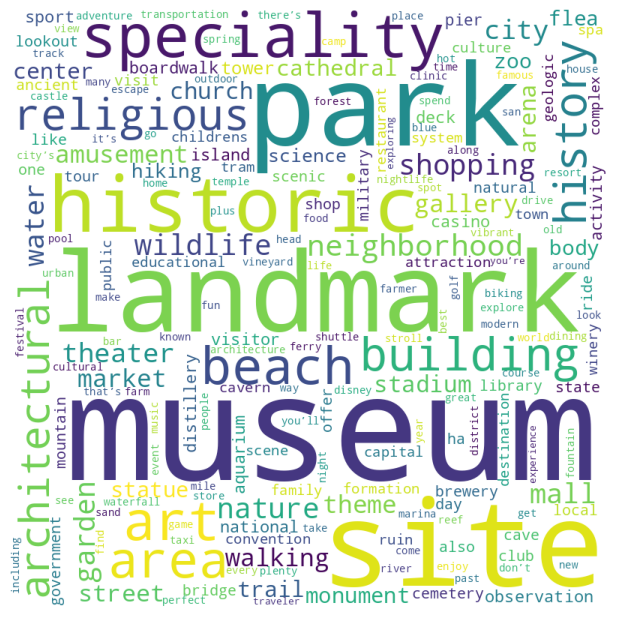

In [15]:
# Concatenate the text data from all rows into a single string
text = ' '.join(combo_df['combo_des'].astype(str).tolist())

# Use a Counter object to count the frequency of each word
word_count = Counter(text.split())

# Generate the word cloud with the frequency information
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10)
wordcloud.generate_from_frequencies(word_count)

# Visualize the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
